In [21]:
!pip install pillow numpy matplotlib pycryptodome --quiet
print("Libraries installed successfully!")

Libraries installed successfully!


In [22]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from Crypto.Random import get_random_bytes
import base64
import hashlib

print("All tools imported and ready!")

All tools imported and ready!


In [23]:
def encrypt_message(message, password):
    """Encrypt message using AES with password"""
    # Generate a random salt
    salt = get_random_bytes(16)
    
    # Derive key from password
    key = hashlib.pbkdf2_hmac('sha256', password.encode(), salt, 100000, 32)
    
    # Create AES cipher
    cipher = AES.new(key, AES.MODE_CBC)
    
    # Encrypt the message
    ct_bytes = cipher.encrypt(pad(message.encode(), AES.block_size))
    
    # Return salt + iv + ciphertext
    return salt + cipher.iv + ct_bytes

def decrypt_message(encrypted_data, password):
    """Decrypt message using password"""
    try:
        # Extract components
        salt = encrypted_data[:16]
        iv = encrypted_data[16:32]
        ct = encrypted_data[32:]
        
        # Derive key from password
        key = hashlib.pbkdf2_hmac('sha256', password.encode(), salt, 100000, 32)
        
        # Create AES cipher
        cipher = AES.new(key, AES.MODE_CBC, iv)
        
        # Decrypt and unpad
        pt = unpad(cipher.decrypt(ct), AES.block_size)
        return pt.decode()
    except:
        return "❌ Decryption failed! Wrong password or corrupted data"

In [24]:
def hide_message(input_image, secret_text, password, output_image):
    """
    Hides encrypted secret text inside an image
    """
    # Encrypt the message first
    encrypted_data = encrypt_message(secret_text, password)
    
    # Convert encrypted data to binary
    binary_data = ''.join(format(byte, '08b') for byte in encrypted_data)
    binary_data += '00000000'  # Add end marker
    
    # Open and prepare image
    img = Image.open(input_image)
    img = img.convert("RGB")
    pixels = np.array(img)
    
    # Check capacity
    required_bits = len(binary_data)
    available_bits = pixels.shape[0] * pixels.shape[1] * 3
    if required_bits > available_bits:
        max_chars = (available_bits // 8) - 48  # Account for encryption overhead
        raise ValueError(f"Message too long! Max characters: {max_chars}")
    
    # Hide data in LSBs
    data_index = 0
    for row in pixels:
        for pixel in row:
            for color_index in range(3):  # R,G,B
                if data_index < required_bits:
                    # Clear LSB
                    pixel[color_index] &= 0b11111110  
                    # Set to data bit
                    pixel[color_index] |= int(binary_data[data_index])
                    data_index += 1
    
    # Save the secret image
    secret_img = Image.fromarray(pixels)
    secret_img.save(output_image)
    print(f"✓ Message hidden in {output_image} with password protection!")
    return secret_img

In [25]:
def reveal_message(encoded_image, password):
    """
    Extracts and decrypts hidden message using password
    """
    img = Image.open(encoded_image)
    pixels = np.array(img)
    
    # Extract LSBs from all pixels
    binary_data = []
    for row in pixels:
        for pixel in row:
            for color in pixel[:3]:
                binary_data.append(str(color & 1))
    
    # Convert to binary string
    binary_string = ''.join(binary_data)
    
    # Split into 8-bit chunks
    bytes_list = [binary_string[i:i+8] for i in range(0, len(binary_string), 8)]
    
    # Find end marker and convert to bytes
    encrypted_bytes = bytearray()
    for byte in bytes_list:
        if byte == '00000000':  # End marker
            break
        encrypted_bytes.append(int(byte, 2))
    
    # Decrypt with password
    return decrypt_message(encrypted_bytes, password)

Original Image:


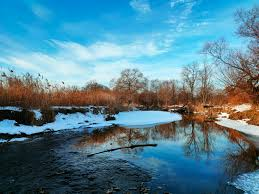

In [26]:
original_image = r"images.jpg"

# Display original image
print("Original Image:")
try:
    display(Image.open(original_image))
except:
    print("Error: Could not find image. Please check filename and upload image to notebook folder.")

✓ Message hidden in protected_image.png with password protection!

Image with hidden message:


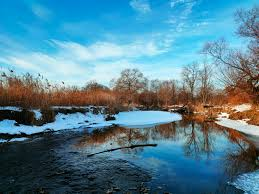

Password used: '123'


In [27]:
# SET YOUR SECRET MESSAGE AND PASSWORD
secret_message = "secret"
password = "123"
secret_image = "protected_image.png"

# Hide the encrypted message
try:
    encoded_img = hide_message(
        input_image=original_image,
        secret_text=secret_message,
        password=password,
        output_image=secret_image
    )
    print("\nImage with hidden message:")
    display(encoded_img)
    print(f"Password used: '{password}'")
except Exception as e:
    print(f"Error: {str(e)}")

In [28]:
# ATTEMPT TO REVEAL THE MESSAGE
user_password = "123" 

decoded_text = reveal_message(secret_image, user_password)

print("\nDecryption Result:")
print("="*50)
print(decoded_text)
print("="*50)

# Verify if correct
if decoded_text == secret_message:
    print("✓ Success! Correct password used.")
elif "❌" in decoded_text:
    print(decoded_text)
else:
    print("❌ Incorrect password! Message decryption failed.")


Decryption Result:
secret
✓ Success! Correct password used.


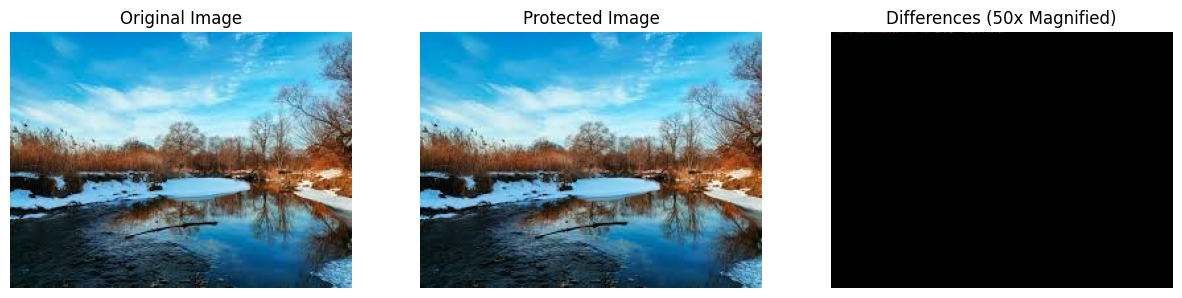

Pixels changed: 0.1181%
Note: Human eye typically can't detect changes < 5%


In [29]:
def compare_images(orig_path, secret_path):
    """Show original vs encoded image comparison"""
    try:
        # Load images
        orig_img = np.array(Image.open(orig_path))
        secret_img = np.array(Image.open(secret_path))
        
        # Create comparison plot
        plt.figure(figsize=(15, 5))
        
        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(orig_img)
        plt.title("Original Image")
        plt.axis('off')
        
        # Secret Image
        plt.subplot(1, 3, 2)
        plt.imshow(secret_img)
        plt.title("Protected Image")
        plt.axis('off')
        
        # Difference (magnified)
        plt.subplot(1, 3, 3)
        plt.imshow(np.abs(orig_img - secret_img) * 50)
        plt.title("Differences (50x Magnified)")
        plt.axis('off')
        
        plt.show()
        
        # Calculate metrics
        diff_percent = np.mean(orig_img != secret_img) * 100
        print(f"Pixels changed: {diff_percent:.4f}%")
        print("Note: Human eye typically can't detect changes < 5%")
        
    except Exception as e:
        print(f"Comparison error: {str(e)}")

# Show comparison
compare_images(original_image, secret_image)

In [32]:
print("Password Security Demonstration:\n")

# Test with wrong passwords
wrong_passwords = [
    "Password123",  
    "12 3",   
    "12",    
    "wrongPassword"   
]

for pwd in wrong_passwords:
    result = reveal_message(secret_image, pwd)
    print(f"Password: '{pwd}'")
    print(f"Result: {result[:60]}{'...' if len(result)>60 else ''}")
    print("-"*60)

Password Security Demonstration:

Password: 'Password123'
Result: ❌ Decryption failed! Wrong password or corrupted data
------------------------------------------------------------
Password: '12 3'
Result: ❌ Decryption failed! Wrong password or corrupted data
------------------------------------------------------------
Password: '12'
Result: ❌ Decryption failed! Wrong password or corrupted data
------------------------------------------------------------
Password: 'wrongPassword'
Result: ❌ Decryption failed! Wrong password or corrupted data
------------------------------------------------------------
